# Product Data Science - NLP Test - Sillas Gonzaga


Este documento contem minha proposta de solução para o desafio de Data Science.



# Importação de módulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn import metrics
from typing import Any, List, Dict, Union
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix

# Importação dos dados e EDA

In [2]:
df = pd.read_csv('B2W-Reviews01.csv')

/tmp/ipykernel_57156/1153590322.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('B2W-Reviews01.csv')


In [3]:
df.head(3)

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP


O dataset fornecido contem muitas colunas interessantes. A própria variável resposta é algo discutível: o que pode ser considerado um review positivo ou negativo? Basta considerar a nota? Poderia ser usada também a coluna recommend_to_a_friend como sinal de sentimento, mas será que é suficiente?

Outro ponto: as únicas variáveis referentes aos clientes são ano de nascimento, sexo (que é melhor não ser usada para evitar introdução de viés sexista no modelo), estado (UF) e reviewer id. Ou seja, caso essas variáveis não tenham uma boa capacidade preditiva, não será possível atender ao desejo da empresa de traçar perfis de clientes mais e menos propensos a comentários positivos ou negativos.

A coluna `reviewer_id` pode ser explorada para investigar a distribuição da quantidade de reviews por cliente.

In [4]:
df['reviewer_id'].value_counts()

6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1ec97c7c958608902ea    155
1cd7f8704e3ebe899a8ff9b5bc485e787a703a67d0c66fce9c260de58e0340fe     75
2c213316c9638030e623f923e3fee14bf191cbab5777e8f5973cdb612b7675c8     64
363bf7b1a7505732379f7a2ae004ecbdc7194b5b774cd844ceebec9321d016b1     62
e34a8ba82a47141e5b2d7fbb53e8b7a7f4222ee64d27d2d4f5e4bf245a0fd4be     61
                                                                   ... 
addfb139418aa6ebed710b07dd3973b1089a806fe9b82eea4ebb0e497a55e3c7      1
f2e46ea69b45e86f1bb866136341dbca4b686655f6c865ac70b3b6cf995a2814      1
450a707391a0910c7f266f5e0dbcad5008b74f2c8ea69ba6b7f45ff2a63604cf      1
e076edaecd6c8afe579e2c7b3f54cf304fef57e101bc43a8be201bbcee0e55b3      1
ea9467aa73271fb4f68c04f4dd4f4eef304d6ee85441fbcd82cda63e620954c3      1
Name: reviewer_id, Length: 112993, dtype: int64

In [5]:
df['reviewer_id'].value_counts().value_counts(normalize = True).sort_index()

1      0.880878
2      0.092785
3      0.017798
4      0.004646
5      0.001673
6      0.000726
7      0.000310
8      0.000327
9      0.000106
10     0.000186
11     0.000062
12     0.000097
13     0.000027
14     0.000062
15     0.000071
16     0.000035
17     0.000018
19     0.000027
20     0.000035
21     0.000018
28     0.000027
29     0.000009
38     0.000009
41     0.000018
50     0.000009
61     0.000009
62     0.000009
64     0.000009
75     0.000009
155    0.000009
Name: reviewer_id, dtype: float64

12% dos clientes fizeram mais de um review, o que pode gerar features interessantes para o modelo.

Curiosamente, um único cliente foi responsável por 155 reviews no dataset. Vamos investigar:

In [6]:
df[df['reviewer_id'] == '6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1ec97c7c958608902ea'].sort_values('submission_date').head(10)

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
10030,2018-01-08 08:19:48,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,29592997,Fatiador Descascador Cortador de Alimentos Leg...,NaN,Utilidades Domésticas,NaN,Adorei o produto,5,Yes,Produto ótimo muito bom mesmo . .........aaaa...,1952.0,M,RJ
10036,2018-01-08 08:23:05,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,30164047,Descascador Cortador Fatiador em Inox de Abaca...,NaN,Utilidades Domésticas,NaN,Produto ótimo .,5,Yes,"Gostei muito do produto produto é muito bom, ó...",1952.0,M,RJ
10046,2018-01-08 08:26:53,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,30164020,Fatiador Descascador Cortador de Alimentos Leg...,NaN,Utilidades Domésticas,NaN,Otímo Produto,5,Yes,Adorei o produto ele é super prático e fácil d...,1952.0,M,RJ
49877,2018-03-05 07:30:04,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,29593011,Garra Cortadora Pegador de Melancia Frutas Pra...,NaN,Utilidades Domésticas,NaN,Super recomendo o produto.,5,Yes,Super recomendo o produto. Todos na minha cas...,1952.0,M,RJ
111995,2018-05-07 11:06:20,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,20644184,Canguru Baby Bag,NaN,Bebês,Passeio,Recomendo .,5,Yes,"Gostei muito do produto, entrega super rápida ...",1952.0,M,RJ
111998,2018-05-07 11:08:58,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,29593221,Kit 30 Brocas Lixa Unha Eletrica Profissional ...,NaN,Beleza e Perfumaria,Unha,Recomendo .,5,Yes,Gostei muito do produto . Entrega super rápida...,1952.0,M,RJ
112004,2018-05-07 11:14:10,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,20824204,Aparelho Massageador Eletroestimulador Para Fi...,NaN,Utilidades Domésticas,Utensílios e Acessórios Domésticos,Recomendo,5,Yes,Gostei muito do produto . Entrega super rápida...,1952.0,M,RJ
112006,2018-05-07 11:14:49,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,29592938,Andador Para Bebes Portatil Criança Moon Walk ...,NaN,Bebês,NaN,Recomendo .,5,Yes,Gostei muito do produto . Entrega super rápida...,1952.0,M,RJ
112007,2018-05-07 11:15:20,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,29593286,Sensor Re Estacionamento Display Led Slim 4 Se...,NaN,Automotivo,NaN,Recomendo .,5,Yes,Gostei muito do produto . Entrega super rápida...,1952.0,M,RJ
112008,2018-05-07 11:15:49,6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1...,29592915,Trena Eletrônica Para Medição De Distância Com...,NaN,Celulares e Smartphones,NaN,Recomendo .,5,Yes,Gostei muito do produto . Entrega super rápida...,1952.0,M,RJ


Os reviews são muito parecidos entre sim, o que nos leva a questionar se os dados precisam de algum processo de limpeza, como remoção de duplicatas.

Investigando a presença de dados nulos no dataset:

In [7]:
df.isna().mean()

submission_date          0.000000
reviewer_id              0.000000
product_id               0.000000
product_name             0.000635
product_brand            0.690405
site_category_lv1        0.000045
site_category_lv2        0.030316
review_title             0.002281
overall_rating           0.000000
recommend_to_a_friend    0.000136
review_text              0.024741
reviewer_birth_year      0.045206
reviewer_gender          0.031245
reviewer_state           0.030150
dtype: float64

A variável mais importante do dataset, `review_text`, contem alguns dados nulos. Como ela sera bastante usada na modelagem, vamos filtrar fora as linhas que contem dados nulos para ela.

In [8]:
df = df[df['review_text'].notnull()]

## Definiçào da variável resposta

In [9]:
df['overall_rating'].value_counts(normalize = True).sort_index().round(3)

1    0.199
2    0.063
3    0.124
4    0.248
5    0.367
Name: overall_rating, dtype: float64

In [10]:
df['recommend_to_a_friend'].value_counts(normalize = True)

Yes    0.736489
No     0.263511
Name: recommend_to_a_friend, dtype: float64

In [11]:
pd.crosstab(df['overall_rating'], df['recommend_to_a_friend'], normalize = 'index').round(2)

recommend_to_a_friend,No,Yes
overall_rating,,
1,0.97,0.03
2,0.75,0.25
3,0.11,0.89
4,0.02,0.98
5,0.01,0.99


A tabela acima mostra resultados muito interessantes: 25% das pessoas que dão nota 2 em um review na verdade recomendariam o produto, o que aparenta ser paradoxal. Portanto, faz sentido criar uma nova variável resposta que seja uma combinação dessas duas: será considerado negativo um review de nota menor ou igual a 2 e que o cliente nào recomendaria para um amigo. Nos demais casos, a avaliaçào é considerada não-negativa.

In [12]:
df['is_negative_review'] = (df['overall_rating'] <= 2) & (df['recommend_to_a_friend'] == 'No')

In [13]:
df['is_negative_review'].mean()

0.2402515918139708

Temos, então, que 24% dos reviews são negativos. Isso é uma informação importante para a modelagem, pois temos que a acurácia do modelo precisa ser maior que o baseline de 82%.

## Separação de treino e teste

Para dar continuidade na EDA e evitar vazamento de dados, os dados serão separados nos conjuntos de treino e teste antes da análise.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df, df['is_negative_review'], random_state=42)

Analisando a variável de categoria dos produtos:

In [15]:
X_train.groupby('site_category_lv1')['is_negative_review'].agg(['size', 'mean']).sort_values('mean', ascending = False)

,size,mean
site_category_lv1,,
Gift Card,1,1.000000
Perfumaria,1,1.000000
Sinalização e Segurança,43,0.488372
Linha Industrial,79,0.468354
Wearable,200,0.425000
"Agro, Indústria e Comércio",196,0.418367
Móveis,5180,0.404826
Suplementos e Vitaminas,905,0.381215
Áudio,1076,0.378253


Os resultados dessa coluna não são muito claros para interpretar: algumas categorias que possuem uma média de avaliações negativas possuem pouquíssimos comentários, o que faz a amostra ser insuficiente para se tirar conclusões.

Analisando o estados dos clientes:

In [16]:
X_train.groupby('reviewer_state')['is_negative_review'].agg(['size', 'mean']).sort_values('mean', ascending = False)

,size,mean
reviewer_state,,
PI,516,0.281008
MS,613,0.269168
CE,1569,0.267686
RJ,12785,0.264529
PA,1100,0.260000
MT,704,0.259943
AM,152,0.256579
MA,903,0.255814
BA,3528,0.253968


Os estados têm uma média de avaliações negativas parecidas entre sim, mostrando que essa variável tem pouco valor preditivo.

## Feature Engineering

É possível criar novas variáveis a partir das existentes no dataset:

In [17]:
# Lower case
X_train['review_text'] = X_train['review_text'].str.lower()
# Add num words of comment as feature
X_train['num_palavras'] = X_train['review_text'].apply(lambda s: len(s.split()))
# Add num words unique of comment as feature
X_train['num_palavras_unicas'] = X_train['review_text'].apply(lambda s: len(set(w for w in s.split())))
# Add num words unique per num words of comment as feature
X_train['palavras_vs_unicas'] = 100 * X_train['num_palavras_unicas'] / X_train['num_palavras']

In [18]:
X_train.describe(percentiles = [0, 0.03, .25, .75, .90, .95, .97])

,overall_rating,reviewer_birth_year,num_palavras,num_palavras_unicas,palavras_vs_unicas
count,96823.000000,92517.000000,96823.00000,96823.000000,96823.000000
mean,3.523388,1977.499184,23.02078,20.110346,92.693067
std,1.515397,22.751907,22.16164,15.634868,9.273506
min,1.000000,59.000000,1.00000,1.000000,0.628931
0%,1.000000,59.000000,1.00000,1.000000,0.628931
3%,1.000000,1951.000000,7.00000,7.000000,73.770492
25%,2.000000,1969.000000,11.00000,11.000000,88.235294
50%,4.000000,1980.000000,16.00000,15.000000,94.444444
75%,5.000000,1987.000000,27.00000,24.000000,100.000000
90%,5.000000,1993.000000,45.00000,38.000000,100.000000


Algumas das variáveis contem outliers, como comentários com 795 palavras. Apesar de outliers assim serem facilmente tratados pelos modelos como os de gradient boosting, eles atrapalham a visualização de dados, portanto serão removidos apenas nesta etapa de EDA.

In [19]:
X_train_clean = X_train[X_train['num_palavras'] <= 75] 
X_train_clean = X_train_clean[X_train_clean['reviewer_birth_year'] >= 1951]

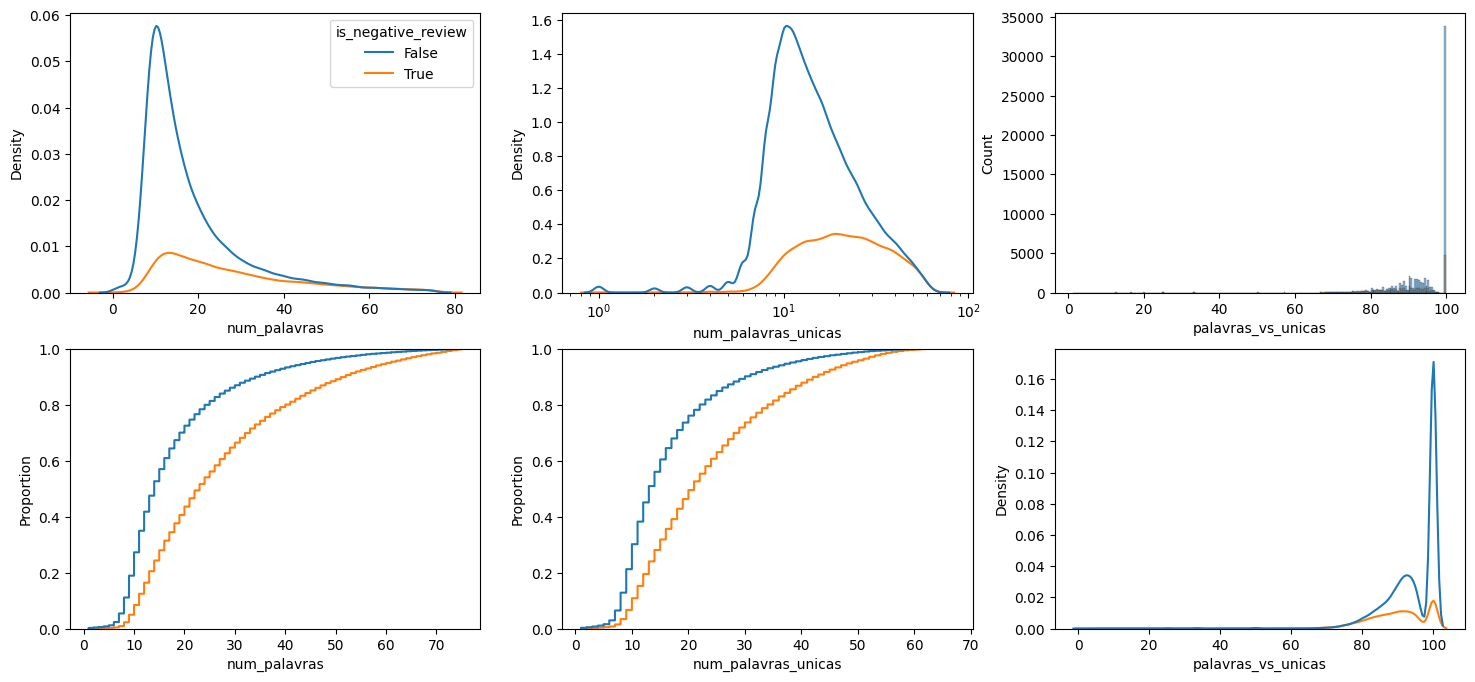

In [20]:
fig, axes = plt.subplots(ncols=3, nrows = 2, figsize=(18,8))


# num_palavras
sns.kdeplot(data = X_train_clean, x = 'num_palavras', hue = 'is_negative_review', ax=axes[0, 0])
sns.ecdfplot(data = X_train_clean, x = 'num_palavras', hue = 'is_negative_review', ax=axes[1, 0], legend=False)
# 
sns.kdeplot(data = X_train_clean, x = 'num_palavras_unicas', hue = 'is_negative_review', log_scale = True, ax=axes[0, 1], legend=False)
sns.ecdfplot(data = X_train_clean, x = 'num_palavras_unicas', hue = 'is_negative_review', ax=axes[1, 1], legend=False)

sns.histplot(data = X_train_clean, x = 'palavras_vs_unicas', hue = 'is_negative_review', ax=axes[0, 2], legend=False)
sns.kdeplot(data = X_train_clean, x = 'palavras_vs_unicas', hue = 'is_negative_review', ax=axes[1, 2], legend=False)

plt.show()

Os gráficos mostram resultados interessantes: 60% das avaliações negativas contem até 30 palavras versus 80% das positivas. Isto é, avaliações negativas possuem mais palavras. 

### TF-IDF

TF-IDF é uma técnica utilizada na área de NLP que tem como objetivo avaliar a importância de uma palavra em um documento. É calculado levando em consideração dois fatores principais: a frequência com que um termo aparece em um documento (TF) e o número de documentos que contêm esse termo (IDF). A frequência de termo é simplesmente a contagem de quantas vezes uma palavra específica aparece em um documento, enquanto a inverso de frequência de documento é uma medida da raridade de um termo em uma coleção de documentos.

Em geral, as palavras que aparecem com frequência em um determinado documento, mas raramente aparecem em outros documentos, são consideradas mais importantes e relevantes para esse documento em particular. Portanto, o TF-IDF atribui um peso maior a essas palavras, em comparação com palavras que aparecem com frequência em todos os documentos.

O TF-IDF é usado em problemas de classificação em machine learning, porque pode ajudar a identificar as palavras-chave que são mais importantes para diferenciar diferentes classes de documentos.

[Eu mesmo já usei TF-IDF no passado](http://sillasgonzaga.com/post/analise-g1-01/) para analisar palavras de destaque comparando notícias de São Paulo com notícias do Rio de Janeiro.

Assim, parece natural usar TF-IDF no contexto deste projeto.

In [21]:
vectorizer = TfidfVectorizer()

In [22]:
X_train_tfidf = vectorizer.fit_transform(X_train['review_text'])
X_test_tfidf = vectorizer.transform(X_test['review_text'])

# Modelagem

Foi construída uma classe para facilitar e automatizar o processo de ajuste, predição e análise de dois modelos: xgboost e lightgbm.

Apenas as variáveis criadas com TF-IDF foram usadas como input nos modelos.

In [23]:
class ModelMetadata:
    """
    Classe para armazenar e analisar metadados de um modelo de classificação.

    Métodos:
    --------
    plot_probabilities():
        Traça uma ECDF das probabilidades previstas da classe positiva para o conjunto de testes.

    set_probability_threshold():
        Define o limite para converter as probabilidades previstas em previsões binárias.

    plot_confusion_matrix():
        Plota a matriz de confusão para o modelo ajustado usando as probabilidades previstas e as etiquetas verdadeiras para o conjunto de testes.

    get_classification_metrics():
        Retorna um dicionário de métricas de classificação para o modelo ajustado usando as probabilidades previstas e as etiquetas verdadeiras para o conjunto de testes.

    plot_metrics_by_threshold():
        Plota a taxa de alarme falso e a taxa de falha por valor de limite.
        
    get_prediction_api():
        Retorna a previsão do modelo para um input em um estilo API.
    """

    
    def __init__(self,
                 model_id: str,
                 model_params_grid_search: Dict[str, Any],
                 model_classifier: Any,
                 y_train: pd.Series = y_train,
                 X_train: csr_matrix = X_train_tfidf,
                 X_test: csr_matrix = X_test_tfidf,
                 y_true: pd.Series = y_test,
                 tf_idf_vectorizer: TfidfVectorizer = vectorizer):
        """
        Inicializa o objeto ModelMetadata.

        Parâmetros:
        -----------
        model_id: str
            O ID do modelo.
        model_params_grid_search: Dict[str, Any]
            O dicionário de parâmetros do modelo a ser avaliado em uma etapa de busca em grade.
            Se None, o código não realizará tuning de parametros.
        model_classifier: Any
            O modelo de classificação a ser ajustado e analisado.
        y_train: pd.Series
            A variável target da amostra de treino.
        X_train: csr_matrix
            A matriz de input da amostra de treino.
        X_test: csr_matrix
            A matriz de input da amostra de teste.
        y_true: pd.Series
            A variável target da amostra de teste.
        tf_idf_vectorizer: TfidfVectorizer
            Objeto que transforma uma serie em uma matriz tf-idf.
        """

        self.model_id = model_id
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_true = y_true
        
        
        self.model_fitted = model_classifier
        self.model_params_grid_search = model_params_grid_search
        
        if self.model_params_grid_search is not None:
            self.model_fitted = GridSearchCV(self.model_fitted, self.model_params_grid_search, cv=3)
        self.model_fitted.fit(self.X_train, self.y_train)
        
        if self.model_params_grid_search is not None:
            self.best_params = self.model_fitted.best_params_
        else:
            self.best_params = self.model_fitted.get_params()
        
        self.y_pred_prob = self.model_fitted.predict_proba(self.X_test)[:, 1]
        self.tf_idf_vectorizer = tf_idf_vectorizer
        
        
        
    def plot_probabilities(self, ax = None):
        """
        Plots an ECDF of the predicted probabilities of the positive class for the testing dataset.
        """
        plt.figure(figsize = (12, 4))
        sns.ecdfplot(pd.Series(self.y_pred_prob), ax = ax)
        ticks = np.arange(0, 1.01, .05)
        plt.xticks(ticks)
        plt.yticks(ticks)
        plt.title(self.model_id)

        plt.show()
        
        
    def set_probability_threshold(self, threshold: float):
        """
        Sets the threshold for converting the predicted probabilities to binary predictions.

        Parameters:
        -----------
        threshold: float
            The threshold value between 0 and 1.
        """
        self.threshold = threshold
        
        
    def plot_tree(self, save_to_pdf: bool = True):
        """
        Plots the decision tree for the fitted model if it is a DecisionTreeClassifier.

        Parameters:
        -----------
        save_to_pdf: bool
            Whether to save the plot as a PDF file.
        """
        if self.model_params_grid_search is not None:
            model = self.model_fitted.best_estimator_
        else:
            model = self.model_fitted
            
        if not isinstance(model, tree.DecisionTreeClassifier):
            print('Tree plot only available for DecisionTreeClassifier')
            return None
        
        fig = plt.figure(figsize = (12, 10))
        tree.plot_tree(model, feature_names = self.features, filled = True)
        if save_to_pdf:
            fig.savefig("decision_tree.pdf")
    
            
    def plot_confusion_matrix(self):
        """
        Plots the confusion matrix for the fitted model using the predicted probabilities and true labels for the testing dataset.
        """
        # get model predictions
        y_pred_bin = np.where(self.y_pred_prob >= self.threshold, 1, 0)

        cm = metrics.confusion_matrix(self.y_true, y_pred_bin)
        cm_plot = metrics.ConfusionMatrixDisplay(cm, display_labels = self.model_fitted.classes_)

        cm_plot.plot()
        plt.tick_params(axis=u'both', which=u'both',length=0)
        plt.show()
        
    def get_classification_metrics(self, threshold:float = None) -> Dict[str, Union[str, float]]:
        """
        Returns a dictionary of classification metrics for the fitted model using the predicted probabilities and true labels for the testing dataset.

        Parameters:
        -----------
        threshold: float
            The threshold used to transform probabilities into binary.

        Returns:
        --------
        Dict[str, Union[str, float]]
            A dictionary of classification metrics, including the model ID, AUC, False Alarm Rate, and Miss Rate.
        """
        
        if threshold is None and self.threshold is not None:
            threshold = self.threshold
        
        # convert probabilistic to binary
        y_pred_bin = self.y_pred_prob >= threshold
        # convert y_true to integer binary
        y_true = self.y_true.values

        auc = metrics.roc_auc_score(y_true = y_true, y_score = self.y_pred_prob)
                
        cm = metrics.confusion_matrix(self.y_true, y_pred_bin)
        tn, fp, fn, tp = cm.ravel()        
        
        fpr = fp / (fp + tn)
        fnr = fn / (tp + fn)
        
        # retornar resultados
        dict_out = {
            'model_id': self.model_id,
            'AUC': np.round(auc, 4),
            'False Alarm Rate': np.round(fpr, 4),
            'Miss Rate': np.round(fnr, 4),
               }

        return(dict_out)

    def plot_metrics_by_threshold(self, ax = None):
        """
        Plots the False Alarm Rate and Miss Rate metrics by threshold value.
        """
        thresholds = np.arange(0, 1.01, .05)
        
        fpr_list = []
        fnr_list = []
        for t in thresholds:
            out = self.get_classification_metrics(t)
            fpr_list.append(out['False Alarm Rate'])
            fnr_list.append(out['Miss Rate'])
            
        
        df_to_plot = pd.DataFrame({'threshold': thresholds, 'False Alarm Rate': fpr_list, 'Miss Rate': fnr_list})
        df_to_plot = df_to_plot.melt(id_vars = 'threshold', var_name = 'metric')
        
        plt.figure(figsize = (12, 6))
        sns.lineplot(data = df_to_plot, x = 'threshold', y = 'value', hue = 'metric', ax = ax)
        plt.xticks(thresholds)
        plt.yticks(thresholds)
        plt.title(self.model_id)
        plt.show()
    
    def get_prediction_api(self, new_data: Dict[str, str]) -> Dict[str, Union[float, bool]]:
        """
        A função "get_prediction_api" é destinada a ser usada em um ambiente de produção como uma API. 

        Dado um novo conjunto de dados, a função retorna um dicionário contendo a estimativa da probabilidade
        de ser um comentário negativo e sua transformação binária considerando o threshold.

        Parameters:
        -----------
        new_data: Dict[str, str]
            Os dados de input para obter a previsão. Deverá ser um dicionário no formato abaixo:
            {"review_text": "{texto a ser transformado em tf-idf}"}

        Returns:
        -----------
        Dict[str, Union[float, bool]
            Dicionario da probabilidade estimada de ser comentario negativo e a resposta binaria do modelo.
        """

        new_data_df = pd.DataFrame(new_data, index = [0])
        new_data_df = self.tf_idf_vectorizer.transform(new_data_df['review_text'])

        prediction_prob = self.model_fitted.predict_proba(new_data_df)[:, 1][0]
        prediction_binary = prediction_prob >= self.threshold

        return {'probabilidade': prediction_prob, 'eh_negativo': prediction_binary}


Devido a limitações computacionais, a pesquisa de parâmetros foi bem simples: apenas dois valores possíveis para um único parâmetro, learning_rate. Com mais tempo e melhores recursos, poderíamos testar mais possibilidades para tunar os parâmetros.

In [24]:
param_grid = {
    'learning_rate': [0.01, 0.1]
}


xgb_model = ModelMetadata(model_id = 'xgboost',
                          model_params_grid_search = param_grid,
                          model_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42))

lightgbm_model = ModelMetadata(model_id = 'lightgbm', 
                               model_params_grid_search = param_grid,
                               model_classifier = lgb.LGBMClassifier(random_state = 42))

In [25]:
lst_models = [xgb_model, lightgbm_model]

Plotando a distribuição das probabilidades.

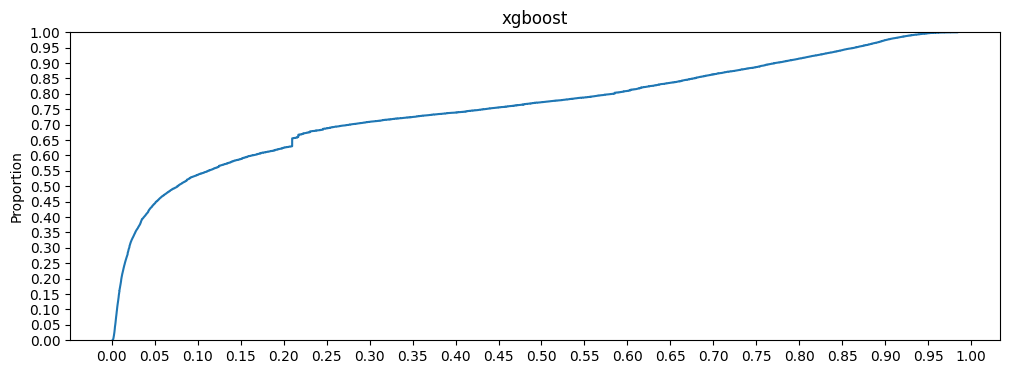

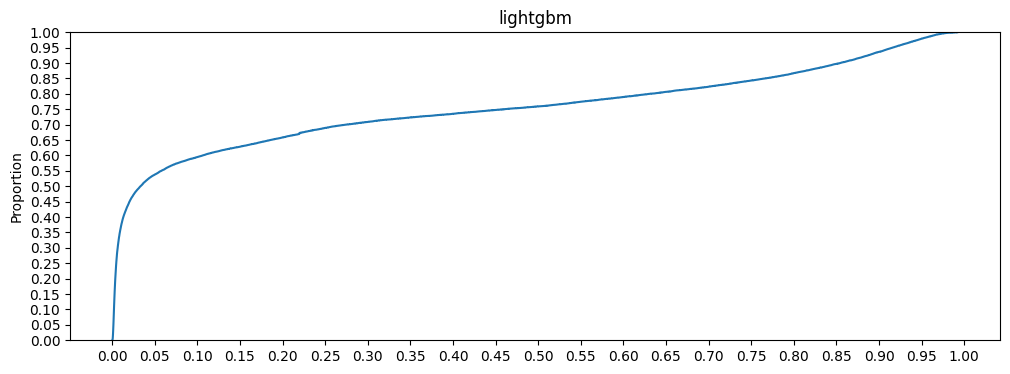

In [26]:
for model in lst_models:
    model.plot_probabilities()


A distribuição das probabilidades dos dois modelos é parecida: aproximadamente 65% dos casos nos dois modelos obtiveram aproximadamente 20% de probabilidade de serem negativos.

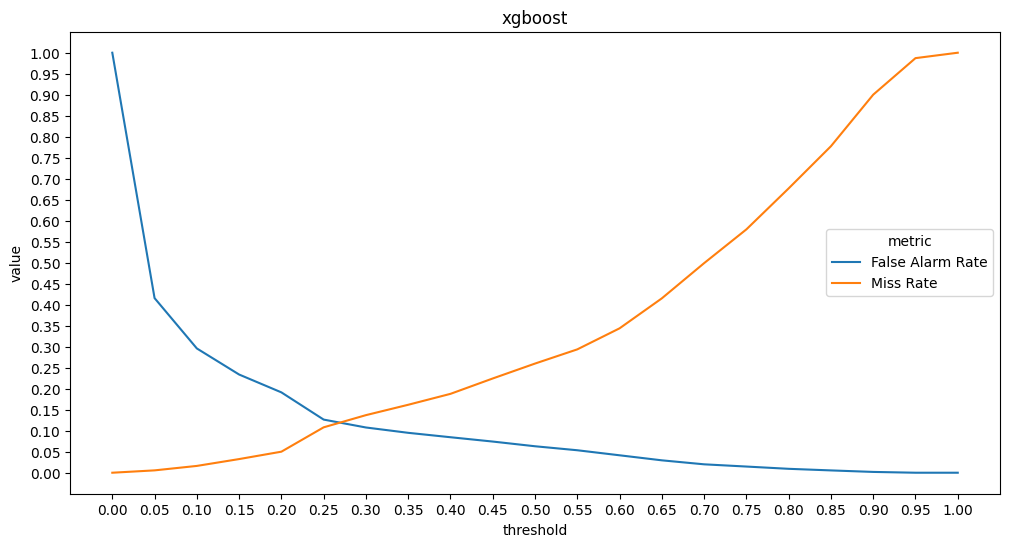

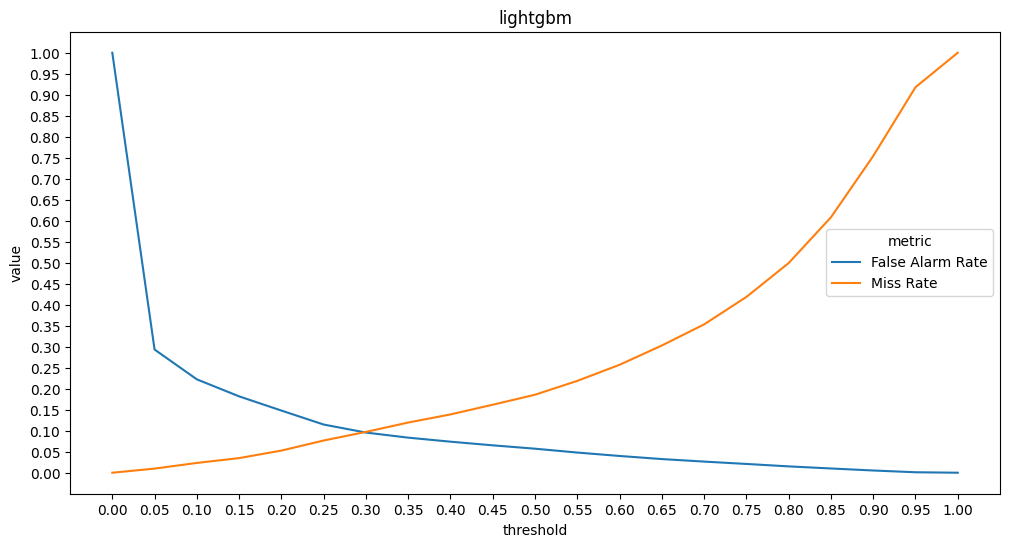

In [27]:
for model in lst_models:
    model.plot_metrics_by_threshold()

O gráfico acima auxilia a escolha de um valor de threshold para usar os modelos como binários: é natural que, quanto maior o threshold, mais comentários serão considerados negativos, o que diminui a taxa de falsos alarmes mas aumenta o Miss Rate. É interessante buscar um equilíbrio.

In [28]:
lst_models[0].set_probability_threshold(0.25)
lst_models[1].set_probability_threshold(0.30)

Defnidos os thresholds, podemos calcular a matriz de confusão e as métricas de classificação dos dois modelos:

xgboost


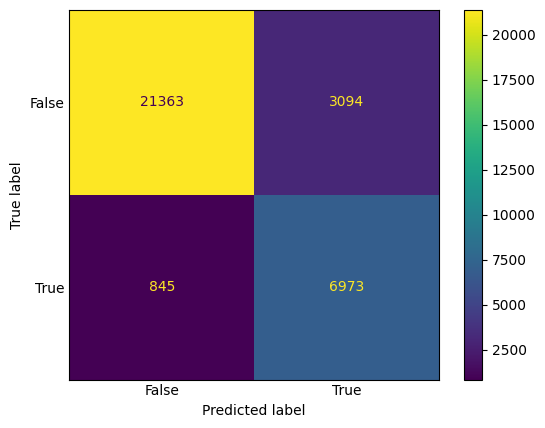

---------
lightgbm


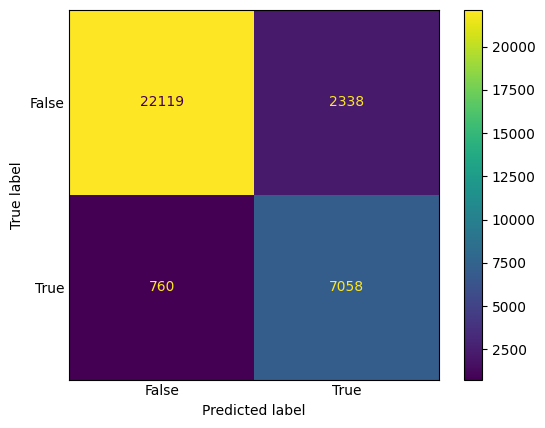

---------


In [29]:
for model in lst_models:
    print(model.model_id)
    model.plot_confusion_matrix()
    print('---------')

In [30]:
pd.DataFrame([model.get_classification_metrics() for model in lst_models])


,model_id,AUC,False Alarm Rate,Miss Rate
0,xgboost,0.9502,0.1265,0.1081
1,lightgbm,0.9632,0.0956,0.0972


O modelo lightgbm foi o melhor dos avaliados. Corretamente previu 7058 dos 7818 comentários negativos, tendo um Miss Rate de apenas 9,7%. Também possui um melhor resultado de False Alarm Rate, tendo corretamente previsto 22119 dos 24457 dos comentários positivos (9,56%)

## Deploy

A classe ModelMetadata já possui um método que facilita o uso do objeto do modelo em um ambiente de produção.

Vamos testar o modelo lightgbm em um exemplo facilmente negativo:

In [31]:
new_data = {'review_text': 'este produto é um lixo total, odiei, nunca mais compro desta marca. simplesmente não funciona. frete demorado.'}

lightgbm_model.get_prediction_api(new_data)

{'probabilidade': 0.9660277541972181, 'eh_negativo': True}